In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation, Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.utils import plot_model

In [2]:
!nvidia-smi

Thu May  6 17:50:33 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla M60           On   | 00000000:00:1E.0 Off |                    0 |
| N/A   38C    P0    38W / 150W |    218MiB /  7618MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
base_dir = './findog2'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'test')

train_datagen = ImageDataGenerator(
        rescale=1/255,    
#        rotation_range=40,
#        width_shift_range=0.1,
#        height_shift_range=0.1,
#        zoom_range=0.2,
#        horizontal_flip=True,
#        vertical_flip=True,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(
     rescale=1/255
)

train_generator = train_datagen.flow_from_directory(
    train_dir, 
#     color_mode='grayscale',
    target_size=(150,150),
    batch_size=100,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
#     color_mode='grayscale',
    target_size=(150,150),
    batch_size=100,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    validation_dir,
#     color_mode='grayscale',
    target_size=(150,150),
    batch_size=100,
    class_mode='categorical'
)

Found 15364 images belonging to 87 classes.
Found 3797 images belonging to 87 classes.
Found 0 images belonging to 87 classes.


# 전이 학습

In [4]:
# pretrained network
model_base = InceptionResNetV2(include_top=False, 
                            weights='imagenet', input_shape=(150,150,3))
# model_base의 weight학습을 동결
model_base.trainable=False

model_base.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
________________________________________________________________________________

In [9]:
model = Sequential()

# pretrained network를 우리의 모델 앞에 추가
model.add(model_base)

model.add(Flatten())

model.add(Dropout(0.5))

model.add(Dense(87, activation='softmax'))

model.summary()

model.compile(optimizer=Adam(learning_rate=1e-4), 
              loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 3, 3, 1536)        54336736  
_________________________________________________________________
flatten_1 (Flatten)          (None, 13824)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 13824)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 87)                1202775   
Total params: 55,539,511
Trainable params: 1,202,775
Non-trainable params: 54,336,736
_________________________________________________________________


# Fine Tuning

In [6]:
'''
model_base.trainable=True

# 상위 layer 동결해제
for layer in model_base.layers:
    if layer.name in ['top_conv','block7b_project_conv', 'block7b_se_expand', 'block7b_se_reduce']:
        layer.trainable=True
    else:
        layer.trainable=False

# learning_rate 더 작게 설정
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy',
              metrics=['accuracy'])
'''

"\nmodel_base.trainable=True\n\n# 상위 layer 동결해제\nfor layer in model_base.layers:\n    if layer.name in ['top_conv','block7b_project_conv', 'block7b_se_expand', 'block7b_se_reduce']:\n        layer.trainable=True\n    else:\n        layer.trainable=False\n\n# learning_rate 더 작게 설정\nmodel.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy',\n              metrics=['accuracy'])\n"

In [7]:
'''
plot_model(model, show_shapes=True, rankdir='TB', dpi=96, 
           to_file='./models/융합프로젝트.png')'''

"\nplot_model(model, show_shapes=True, rankdir='TB', dpi=96, \n           to_file='./models/융합프로젝트.png')"

In [10]:
history = model.fit(train_generator, steps_per_epoch=150, epochs=30,
                    validation_data=validation_generator, validation_steps=37)

Epoch 1/30
150/150 [==============================] - 66s 374ms/step - loss: 4.7731 - accuracy: 0.3249 - val_loss: 1.3590 - val_accuracy: 0.7086
Epoch 2/30
150/150 [==============================] - 51s 343ms/step - loss: 2.1809 - accuracy: 0.6083 - val_loss: 1.3480 - val_accuracy: 0.7273
Epoch 3/30
150/150 [==============================] - 51s 343ms/step - loss: 1.8298 - accuracy: 0.6604 - val_loss: 1.3561 - val_accuracy: 0.7403
Epoch 4/30
150/150 [==============================] - 51s 343ms/step - loss: 1.7075 - accuracy: 0.6792 - val_loss: 1.3585 - val_accuracy: 0.7257
Epoch 5/30
150/150 [==============================] - 51s 343ms/step - loss: 1.6035 - accuracy: 0.6900 - val_loss: 1.3331 - val_accuracy: 0.7422
Epoch 6/30
150/150 [==============================] - 52s 343ms/step - loss: 1.4415 - accuracy: 0.7093 - val_loss: 1.3406 - val_accuracy: 0.7430
Epoch 7/30
150/150 [==============================] - 52s 343ms/step - loss: 1.3545 - accuracy: 0.7231 - val_loss: 1.3236 - val_ac

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


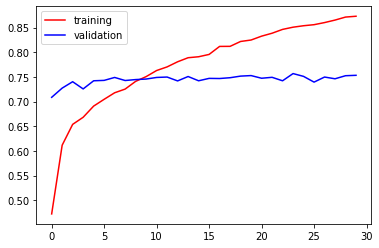

In [11]:
# history 객체 확인
print(history.history.keys())

train_acc = history.history['accuracy']
validation_acc = history.history['val_accuracy']

train_loss = history.history['loss']
validation_loss = history.history['val_loss']

plt.plot(train_acc, color='r', label='training')
plt.plot(validation_acc, color='b', label='validation')
plt.legend()
#plt.savefig('./models/InceptionResNetV2_1/InceptionResNetV2_1-1_acc.jpg')
plt.show()

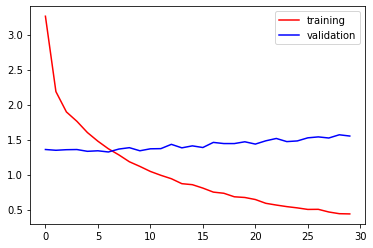

In [12]:
plt.plot(train_loss, color='r', label='training')
plt.plot(validation_loss, color='b', label='validation')
plt.legend()
#plt.savefig('./models/InceptionResNetV2_1/InceptionResNetV2_1-1_val.jpg')
plt.show()

In [13]:
result = model.evaluate(validation_generator)
print(np.round(result, 4))

38/38 [==============================] - 12s 307ms/step - loss: 1.5666 - accuracy: 0.7524
[1.5666 0.7524]


In [ ]:
#model.save('./models/InceptionResNetV2_1/InceptionResNetV2_1-1.h5')